## MNIST Example in [[1609.09106] HyperNetworks](http://blog.otoro.net/2016/09/28/hyper-networks/) ##

This notebook will reproduce the MNIST experiment in the HyperNetworks paper.  This is a very simple experiment, involving a small modification to the TensorFlow [MNIST tutorial](https://www.tensorflow.org/versions/r0.9/tutorials/mnist/pros/index.html). We will express an MNIST Kernel $W$ with using a vector $z$ consisting of four values, by making $W(z)$t a function of $z$.  This concept can be extended to deeper convnet architectures, such as [Deep Residual Networks](https://github.com/tensorflow/models/tree/master/resnet), if we keep the same $W(z)$ weight generation function for each layer, but learn a different $z$ unique for each layer.  The MNIST experiment in the paper will apply this method to only one layer as a simple proof of concept.

<img src="https://cdn.rawgit.com/hardmaru/supercell/master/assets/static_hyper_network.svg">

In addition to HyperNetworks, the process of compressing weights with embedding vectors have been explored before, for example, in these very interesting papers: [Predicting Parameters in Deep Learning](https://arxiv.org/abs/1306.0543) and [Deep Friend Convnets](https://arxiv.org/abs/1412.7149).  In fact, you can even make the weight kernels $W$ a function of the input image, so that the weights can be custom tailored for the input, and this is explored in a recent paper called [Dynamic Filter Networks](https://arxiv.org/abs/1605.09673).  In the HyperNetworks paper, we try to take this a bit further and explore this concept with recurrent networks as well.

This MNIST example is based off TensorFlow's [MNIST Example](https://www.tensorflow.org/versions/r0.9/tutorials/mnist/pros/index.html) and the architecture is almost identical.

The only difference is that in a typical convnet architecture, the weights are a trainable tensor:

`conv_weights = tf.Variable(tf.truncated_normal([f_size, f_size, in_size, out_size], stddev=0.01), name="conv_weights")`

As you will see later, `conv_weights` will be the output of a hypernetwork instead of a `tf.Variable`.

In [1]:
# includes

%matplotlib inline

import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import PIL
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

# misc
np.set_printoptions(precision=5, edgeitems=8, linewidth=200)

Support Functions:

In [2]:
def orthogonal(shape):
  flat_shape = (shape[0], np.prod(shape[1:]))
  a = np.random.normal(0.0, 1.0, flat_shape)
  u, _, v = np.linalg.svd(a, full_matrices=False)
  q = u if u.shape == flat_shape else v
  return q.reshape(shape)
def orthogonal_initializer(scale=1.0):
  def _initializer(shape, dtype=tf.float32, partition_info=None):
    return tf.constant(orthogonal(shape) * scale, dtype)
  return _initializer

In [3]:
def super_linear(x, output_size, scope=None, reuse=False, init_w="ortho", weight_start=0.0, use_bias=True, bias_start=0.0):
  # support function doing linear operation.  uses ortho initializer defined earlier.
  shape = x.get_shape().as_list()
  with tf.variable_scope(scope or "linear"):
    if reuse == True:
      tf.get_variable_scope().reuse_variables()

    w_init = None # uniform
    x_size = shape[1]
    h_size = output_size
    if init_w == "zeros":
      w_init=tf.constant_initializer(0.0)
    elif init_w == "constant":
      w_init=tf.constant_initializer(weight_start)
    elif init_w == "gaussian":
      w_init=tf.random_normal_initializer(stddev=weight_start)
    elif init_w == "ortho":
      w_init=orthogonal_initializer(1.0)

    w = tf.get_variable("super_linear_w",
      [shape[1], output_size], tf.float32, initializer=w_init)
    if use_bias:
      b = tf.get_variable("super_linear_b", [output_size], tf.float32,
        initializer=tf.constant_initializer(bias_start))
      return tf.matmul(x, w) + b
    return tf.matmul(x, w)

Useful class to hold MNIST Data and do data augmentation / scrambling / batching.

In [4]:
# class to store mnist data
class DataSet(object):
  def __init__(self, images, labels, augment=False):
    # Convert from [0, 255] -> [0.0, 1.0] -> [-1.0, 1.0]
    images = images.astype(np.float32)
    #images = images - 0.5
    #images = 2.0 * images
    self.image_size = 28
    self._num_examples = len(images)
    images = np.reshape(images, (self._num_examples, self.image_size, self.image_size, 1))
    perm = np.arange(self._num_examples)
    np.random.shuffle(perm)
    self._images = images[perm]
    self._labels = labels[perm]
    self._augment = augment
    self.pointer = 0
    self.upsize = 1 if self._augment else 0
    self.min_upsize = 2
    self.max_upsize = 2
    self.random_perm_mode=False
    self.num_classes = 10

  @property
  def images(self):
    return self._images
  @property
  def labels(self):
    return self._labels
  @property
  def num_examples(self):
    return self._num_examples

  def next_batch(self, batch_size=100, with_label = True, one_hot = False):
    if self.pointer >= self.num_examples-2*batch_size:
      self.pointer = 0
    else:
      self.pointer += batch_size
    result = []
    
    upsize_amount = np.random.randint(self.upsize*self.min_upsize, self.upsize*self.max_upsize+1)
    
    #def random_flip(x):
    #  if np.random.rand(1)[0] > 0.5:
    #    return np.fliplr(x)
    #  return x

    def upsize_row_once(img):
      old_size = img.shape[0]
      new_size = old_size+1
      new_img = np.zeros((new_size, img.shape[1], 1))
      rand_row = np.random.randint(1, old_size-1)
      new_img[0:rand_row,:] = img[0:rand_row,:]
      new_img[rand_row+1:,:] = img[rand_row:,:]
      new_img[rand_row,:] = 0.5*(new_img[rand_row-1,:]+new_img[rand_row+1,:])
      return new_img
    def upsize_col_once(img):
      old_size = img.shape[1]
      new_size = old_size+1
      new_img = np.zeros((img.shape[0], new_size, 1))
      rand_col = np.random.randint(1, old_size-1)
      new_img[:,0:rand_col,:] = img[:,0:rand_col,:]
      new_img[:,rand_col+1:,:] = img[:,rand_col:,:]
      new_img[:,rand_col,:] = 0.5*(new_img[:,rand_col-1,:]+new_img[:,rand_col+1,:])
      return new_img
    def upsize_me(img, n=self.max_upsize):
      new_img = img
      for i in range(n):
        new_img = upsize_row_once(new_img)
        new_img = upsize_col_once(new_img)
      return new_img

    for data in self._images[self.pointer:self.pointer+batch_size]:
      result.append(self.distort_image(upsize_me(data, upsize_amount), upsize_amount))
      
    if len(result) != batch_size:
      print "uh oh, self.pointer = ", self.pointer
    assert(len(result) == batch_size)
    result_labels = self.labels[self.pointer:self.pointer+batch_size]
    assert(len(result_labels) == batch_size)
    if one_hot:
      result_labels = np.eye(self.num_classes)[result_labels]
    if with_label:
      return self.scramble_batch(np.array(result, dtype=np.float32)), result_labels
    return self.scramble_batch(np.array(result, dtype=np.float32))

  def distort_batch(self, batch, upsize_amount):
    batch_size = len(batch)
    row_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1, batch_size)
    col_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1, batch_size)
    result = np.zeros(shape=(batch_size, self.image_size, self.image_size, 1), dtype=np.float32)
    for i in range(batch_size):
      result[i, :, :, :] = batch[i, row_distort[i]:row_distort[i]+self.image_size, col_distort[i]:col_distort[i]+self.image_size, :]
    return result
  def scramble_batch(self, batch):
    if self.random_perm_mode:
      batch_size = len(batch)
      result = np.copy(batch)
      result = result.reshape(batch_size, self.image_size*self.image_size)
      result = result[:, self.random_key]
      return result
    else:
      result = batch
      return result
  def distort_image(self, img, upsize_amount):
    row_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1)
    col_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1)
    result = np.zeros(shape=(self.image_size, self.image_size, 1), dtype=np.float32)
    result[:, :, :] = img[row_distort:row_distort+self.image_size, col_distort:col_distort+self.image_size, :]
    return result

  def shuffle_data(self):
    perm = np.arange(self._num_examples)
    np.random.shuffle(perm)
    self._images = self._images[perm]
    self._labels = self._labels[perm]

In [5]:
# show image of mnist
def show_image(image):
  plt.subplot(1, 1, 1)
  plt.imshow(np.reshape(image, (28, 28)), cmap='Greys', interpolation='nearest')
  plt.axis('off')
  plt.show()

In [6]:
def show_filter(w_orig):
  w = w_orig.T
  the_shape = w_orig.shape
  print the_shape
  f_size = the_shape[0]
  in_dim =the_shape[2]
  out_dim = the_shape[3]
  print "mean =", np.mean(w)
  print "stddev =", np.std(w)
  print "max =", np.max(w)
  print "min =", np.min(w)
  print "median =", np.median(w)
  canvas = np.zeros(((f_size+1)*out_dim, (f_size+1)*in_dim))
  for i in range(out_dim):
    for j in range(in_dim):
      canvas[i*(f_size+1):i*(f_size+1)+f_size,j*(f_size+1):j*(f_size+1)+f_size] = w[i, j]
  plt.figure(figsize=(16, 16))
  canvas_fixed = np.zeros((canvas.shape[0]+1,canvas.shape[1]+1))
  canvas_fixed[1:,1:] = canvas
  plt.imshow(canvas_fixed.T, cmap='Greys', interpolation='nearest')
  plt.axis('off')

In [7]:
def read_data_sets(mnist_data):

  class DataSets(object):
    pass
  data_sets = DataSets()

  data_sets.train = DataSet(mnist_data.train.images, mnist_data.train.labels, augment=True)
  data_sets.valid = DataSet(mnist_data.validation.images, mnist_data.validation.labels, augment=False)
  data_sets.test = DataSet(mnist_data.test.images, mnist_data.test.labels, augment=False)
  XDIM = data_sets.train.image_size
  #random_key = np.random.permutation(XDIM*XDIM)
  #data_sets.train.random_key = random_key
  #data_sets.valid.random_key = random_key
  #data_sets.test.random_key = random_key
  return data_sets

MNIST Model below handles normal convnet and static hypernetwork approach outlined in paper.

In [8]:
class MNIST(object):
  def __init__(self, hps_model, reuse=False, gpu_mode=True, is_training=True):
    self.is_training = is_training
    with tf.variable_scope('conv_mnist', reuse=reuse):
      if not gpu_mode:
        with tf.device("/cpu:0"):
          print "model using cpu"
          self.build_model(hps_model)
      else:
        self.build_model(hps_model)

  def build_model(self, hps_model):

    self.hps = hps_model
    
    self.model_path = self.hps.model_path
    self.model_save_path = self.model_path + 'mnist'
    
    self.batch_images = tf.placeholder(tf.float32, [self.hps.batch_size, self.hps.x_dim, self.hps.x_dim, self.hps.c_dim])
    self.batch_labels = tf.placeholder(tf.float32, [self.hps.batch_size, self.hps.num_classes]) # one-hot labels.
    
    '''
    settings for architecture:
    '''
    f_size=7
    in_size=16
    out_size=16
    z_dim=4

    conv1_weights = tf.Variable(tf.truncated_normal([f_size, f_size, 1, out_size], stddev=0.01), name="conv1_weights")
    
    if self.hps.hyper_mode:
      # the static hypernetwork is inside this if statement.
      w1 = tf.get_variable('w1',[z_dim, out_size*f_size*f_size],initializer=tf.truncated_normal_initializer(stddev=0.01))
      b1 = tf.get_variable('b1', [out_size*f_size*f_size], initializer=tf.constant_initializer(0.0))
      z2 = tf.get_variable("z_signal_2", [1, z_dim], tf.float32, initializer=tf.truncated_normal_initializer(0.01))
      w2 = tf.get_variable('w2',[z_dim, in_size*z_dim],initializer=tf.truncated_normal_initializer(stddev=0.01))
      b2 = tf.get_variable('b2', [in_size*z_dim], initializer=tf.constant_initializer(0.0))
      h_in = tf.matmul(z2, w2) + b2
      h_in = tf.reshape(h_in, [in_size, z_dim])
      h_final = tf.matmul(h_in, w1) + b1
      kernel2 = tf.reshape(h_final, (out_size, in_size, f_size, f_size))
      conv2_weights = tf.transpose(kernel2)
    else:
      conv2_weights = tf.Variable(tf.truncated_normal([f_size, f_size, in_size, out_size], stddev=0.01), name="conv2_weights")

    self.conv1_weights = conv1_weights
    self.conv2_weights = conv2_weights

    conv1_biases = tf.Variable(tf.zeros([in_size]), name="conv1_biases")

    net = tf.nn.conv2d(self.batch_images, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
    net = tf.nn.relu(net + conv1_biases)
    net = tf.nn.max_pool(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_biases = tf.Variable(tf.zeros([out_size]), name="conv2_biases")

    net = tf.nn.conv2d(net, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    net = tf.nn.relu(net + conv2_biases)
    net = tf.nn.max_pool(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Reshapes the hidden units such that instead of 2D maps, they are 1D vectors:
    net = tf.reshape(net, [self.hps.batch_size, -1])
    
    net = super_linear(net, self.hps.num_classes, scope='fc_final')
    
    self.logits = net
    self.probabilities = tf.nn.softmax(self.logits)
    self.predictions = tf.argmax(self.logits, 1)

    # Specify the loss function:
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.batch_labels)
    self.loss = tf.reduce_mean(cross_entropy)
    #tf.scalar_summary('Total Loss', self.loss)
    
    # Specify the optimization scheme:
    self.lr = tf.Variable(self.hps.lr, trainable=False)
    optimizer = tf.train.AdamOptimizer(self.lr)
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars),
            self.hps.grad_clip)
    self.train_op = optimizer.apply_gradients(zip(grads, tvars))

    # model saver
    self.saver = tf.train.Saver(tf.all_variables())
  def update_lr(self, sess):
    lr = sess.run(self.lr)
    lr *= self.hps.lr_decay
    sess.run(tf.assign(model.lr, np.maximum(lr, self.hps.min_lr)))
  def partial_train(self, sess, batch_images, batch_labels):
    _, loss, pred, lr = sess.run((self.train_op, self.loss, self.predictions, self.lr),feed_dict={self.batch_images: batch_images, self.batch_labels: batch_labels})
    return loss, pred, lr
  def partial_eval(self, sess, batch_images, batch_labels):
    loss, pred = sess.run((self.loss, self.predictions),feed_dict={self.batch_images: batch_images, self.batch_labels: batch_labels})
    return loss, pred
  def save_model(self, sess, epoch = 0):
    checkpoint_path=self.model_save_path
    print "saving model: ", checkpoint_path
    self.saver.save(sess, checkpoint_path, global_step = epoch)
  def load_model(self, sess):
    checkpoint_path = self.model_path
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    print "loading model: ", ckpt.model_checkpoint_path
    self.saver.restore(sess, ckpt.model_checkpoint_path)

Training functions to handle early stopping with validation set.

In [9]:
# training
def process_epoch(sess, model, dataset, train_mode=False, print_every=0):
  
  num_examples = dataset.num_examples
  batch_size = hps_model.batch_size
  total_batch = int(num_examples / batch_size)
  
  avg_loss = 0.
  avg_pred_error = 0.
  lr = model.hps.lr

  for i in range(total_batch):
    batch_images, batch_labels = dataset.next_batch(batch_size, with_label = True, one_hot = False)

    if train_mode:
      loss, pred, lr = model.partial_train(sess, batch_images, np.eye(dataset.num_classes)[batch_labels])
      model.update_lr(sess)
    else:
      loss, pred = model.partial_eval(sess, batch_images, np.eye(dataset.num_classes)[batch_labels])

    pred_error = 1.0 - np.sum((pred == batch_labels)) / float(batch_size)
    
    if print_every > 0 and i > 0 and i % print_every == 0:
      print "Batch:", '%d' % (i), \
            "/", '%d' % (total_batch), \
            "loss=", "{:.4f}".format(loss), \
            "err=", "{:.4f}".format(pred_error)
        
    assert( loss < 1000000 ) # make sure it is not NaN or Inf

    avg_loss += loss / num_examples * batch_size
    avg_pred_error += pred_error / num_examples * batch_size
  return avg_loss, avg_pred_error, lr

def train_model(sess, model, eval_model, mnist, num_epochs, save_model = True):
  # train the model for num_epochs

  best_valid_loss = 100.
  best_valid_pred_error = 1.0
  eval_loss = 100.
  eval_pred_error = 1.0
  
  for epoch in range(num_epochs):

    train_loss, train_pred_error, lr = process_epoch(sess, model, mnist.train, train_mode=True, print_every = 10)
    
    valid_loss, valid_pred_error, _ = process_epoch(sess, eval_model, mnist.valid, train_mode=False)
    
    if valid_pred_error <= best_valid_pred_error:
      best_valid_pred_error = valid_pred_error
      best_valid_loss = valid_loss
      eval_loss, eval_pred_error, _ = process_epoch(sess, eval_model, mnist.test, train_mode=False)
      
      if (save_model):
        model.save_model(sess, epoch)

    print "Epoch:", '%d' % (epoch), \
          "train_loss=", "{:.4f}".format(train_loss), \
          "train_err=", "{:.4f}".format(train_pred_error), \
          "valid_err=", "{:.4f}".format(valid_pred_error), \
          "best_valid_err=", "{:.4f}".format(best_valid_pred_error), \
          "test_err=", "{:.4f}".format(eval_pred_error), \
          "lr=", "{:.6f}".format(lr)

Train a vanilla convnet, with no hypernetworks, as a baseline ( `hps_model.hyper_mode = False` ):

In [10]:
class HParams(object):
  pass

hps_model = HParams()
hps_model.lr=0.005
hps_model.lr_decay=0.999
hps_model.min_lr=0.0001
hps_model.is_training=True
hps_model.x_dim=28
hps_model.num_classes=10
hps_model.c_dim=1
hps_model.batch_size=1000
hps_model.grad_clip=100.0
hps_model.hyper_mode=False
hps_model.model_path='/tmp/'

In [11]:
mnist_data = input_data.read_data_sets("/tmp/data/", one_hot=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [12]:
mnist = read_data_sets(mnist_data)

In [13]:
tf.reset_default_graph()
model = MNIST(hps_model)

In [14]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [15]:
train_model(sess, model, model, mnist, 50, save_model = False)

Batch: 10 / 55 loss= 1.0541 err= 0.3210
Batch: 20 / 55 loss= 0.5839 err= 0.1800
Batch: 30 / 55 loss= 0.4239 err= 0.1310
Batch: 40 / 55 loss= 0.2512 err= 0.0700
Batch: 50 / 55 loss= 0.1925 err= 0.0620
Epoch: 0 train_loss= 0.6716 train_err= 0.2169 valid_err= 0.0294 best_valid_err= 0.0294 test_err= 0.0329 lr= 0.004737
Batch: 10 / 55 loss= 0.1849 err= 0.0480
Batch: 20 / 55 loss= 0.1379 err= 0.0390
Batch: 30 / 55 loss= 0.1696 err= 0.0500
Batch: 40 / 55 loss= 0.1515 err= 0.0460
Batch: 50 / 55 loss= 0.0992 err= 0.0300
Epoch: 1 train_loss= 0.1370 train_err= 0.0420 valid_err= 0.0182 best_valid_err= 0.0182 test_err= 0.0176 lr= 0.004483
Batch: 10 / 55 loss= 0.1173 err= 0.0400
Batch: 20 / 55 loss= 0.0813 err= 0.0270
Batch: 30 / 55 loss= 0.0650 err= 0.0240
Batch: 40 / 55 loss= 0.1098 err= 0.0350
Batch: 50 / 55 loss= 0.0700 err= 0.0180
Epoch: 2 train_loss= 0.0891 train_err= 0.0277 valid_err= 0.0190 best_valid_err= 0.0182 test_err= 0.0176 lr= 0.004243
Batch: 10 / 55 loss= 0.0713 err= 0.0210
Batch: 20

A vanilla convnet baseline has `test_err = 0.77%`.  Note that we use the model based that obtained the lowest error on the validation set.

From the below, we see that the main filter is composed of 12544 parameters.

In [16]:
t_vars = tf.trainable_variables()
count_t_vars = 0
for var in t_vars:
  num_param = np.prod(var.get_shape().as_list())
  count_t_vars += num_param
  print var.name, var.get_shape(), num_param
print "total trainable variables = %d" % (count_t_vars)

conv_mnist/conv1_weights:0 (7, 7, 1, 16) 784
conv_mnist/conv2_weights:0 (7, 7, 16, 16) 12544
conv_mnist/conv1_biases:0 (16,) 16
conv_mnist/conv2_biases:0 (16,) 16
conv_mnist/fc_final/super_linear_w:0 (784, 10) 7840
conv_mnist/fc_final/super_linear_b:0 (10,) 10
total trainable variables = 21210


In [17]:
conv_filter = sess.run((model.conv2_weights))

This is what a normal convnet filter trained to classify MNIST looks like:

(7, 7, 16, 16)
mean = -0.0134218
stddev = 0.116064
max = 0.60943
min = -0.763699
median = -0.00758618


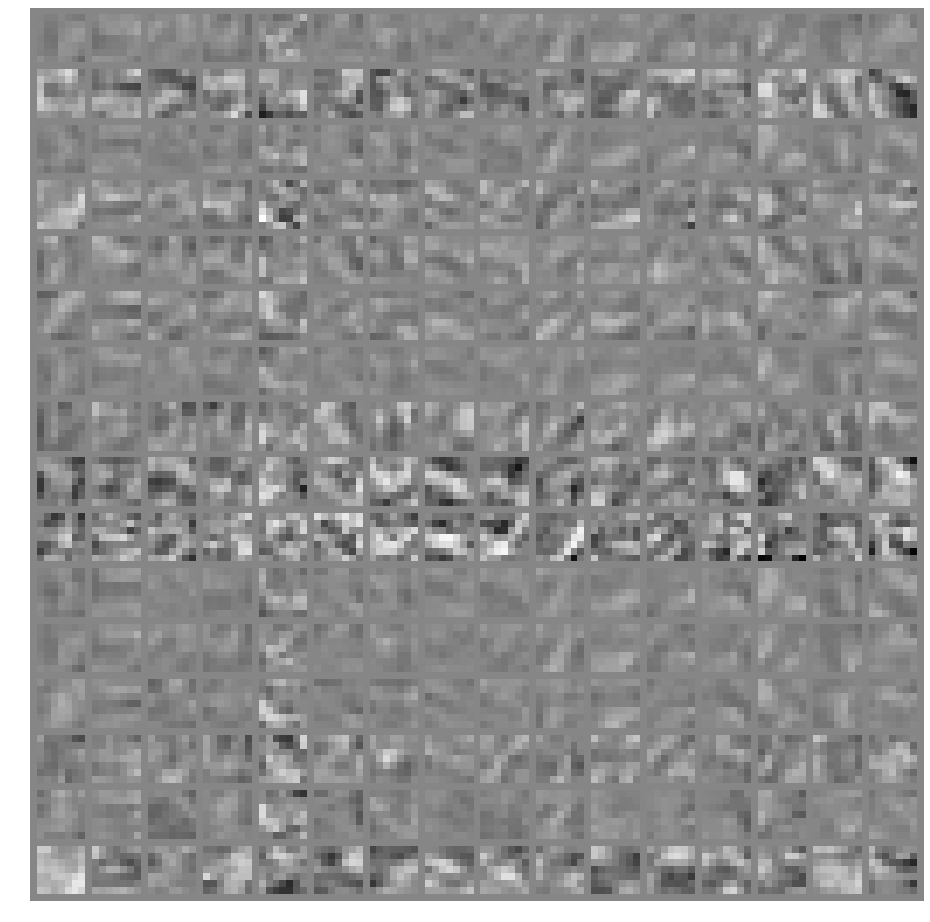

In [18]:
show_filter(conv_filter)

So far we have done nothing really that new.  Next, we will train a convnet with an embedded static hypernetwork, and set `hps_model.hyper_mode = True`:

In [19]:
hps_model.hyper_mode=True

In [20]:
sess.close()
tf.reset_default_graph()
model = MNIST(hps_model)
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [21]:
train_model(sess, model, model, mnist, 50, save_model = False)

Batch: 10 / 55 loss= 1.0669 err= 0.3680
Batch: 20 / 55 loss= 0.7488 err= 0.2350
Batch: 30 / 55 loss= 0.5975 err= 0.1760
Batch: 40 / 55 loss= 0.5290 err= 0.1650
Batch: 50 / 55 loss= 0.4634 err= 0.1450
Epoch: 0 train_loss= 0.8464 train_err= 0.2803 valid_err= 0.0686 best_valid_err= 0.0686 test_err= 0.0655 lr= 0.004737
Batch: 10 / 55 loss= 0.3537 err= 0.1160
Batch: 20 / 55 loss= 0.2714 err= 0.0800
Batch: 30 / 55 loss= 0.2280 err= 0.0760
Batch: 40 / 55 loss= 0.2260 err= 0.0640
Batch: 50 / 55 loss= 0.1926 err= 0.0570
Epoch: 1 train_loss= 0.2724 train_err= 0.0827 valid_err= 0.0354 best_valid_err= 0.0354 test_err= 0.0327 lr= 0.004483
Batch: 10 / 55 loss= 0.1866 err= 0.0550
Batch: 20 / 55 loss= 0.2063 err= 0.0580
Batch: 30 / 55 loss= 0.1469 err= 0.0460
Batch: 40 / 55 loss= 0.1567 err= 0.0510
Batch: 50 / 55 loss= 0.1299 err= 0.0470
Epoch: 2 train_loss= 0.1555 train_err= 0.0472 valid_err= 0.0254 best_valid_err= 0.0254 test_err= 0.0238 lr= 0.004243
Batch: 10 / 55 loss= 0.1487 err= 0.0480
Batch: 20

A convnet where the main filter is generated by a static hypernetwork has `test_err = 0.79%`

In [22]:
conv_filter = sess.run((model.conv2_weights))

We see that the hypernetwork has 4240 parameters (3136+784+256+64), along with an embedding vector $z$ of size 4.  The hypernetwork generates a weight filter of size 12544.

In [23]:
t_vars = tf.trainable_variables()
count_t_vars = 0
for var in t_vars:
  num_param = np.prod(var.get_shape().as_list())
  count_t_vars += num_param
  print var.name, var.get_shape(), num_param
print "total trainable variables = %d" % (count_t_vars)

conv_mnist/conv1_weights:0 (7, 7, 1, 16) 784
conv_mnist/w1:0 (4, 784) 3136
conv_mnist/b1:0 (784,) 784
conv_mnist/z_signal_2:0 (1, 4) 4
conv_mnist/w2:0 (4, 64) 256
conv_mnist/b2:0 (64,) 64
conv_mnist/conv1_biases:0 (16,) 16
conv_mnist/conv2_biases:0 (16,) 16
conv_mnist/fc_final/super_linear_w:0 (784, 10) 7840
conv_mnist/fc_final/super_linear_b:0 (10,) 10
total trainable variables = 12910


This is what a hypernetwork generated convnet filter trained to classify MNIST looks like:

(7, 7, 16, 16)
mean = -0.0102939
stddev = 0.187011
max = 0.850576
min = -1.0306
median = -0.00377694


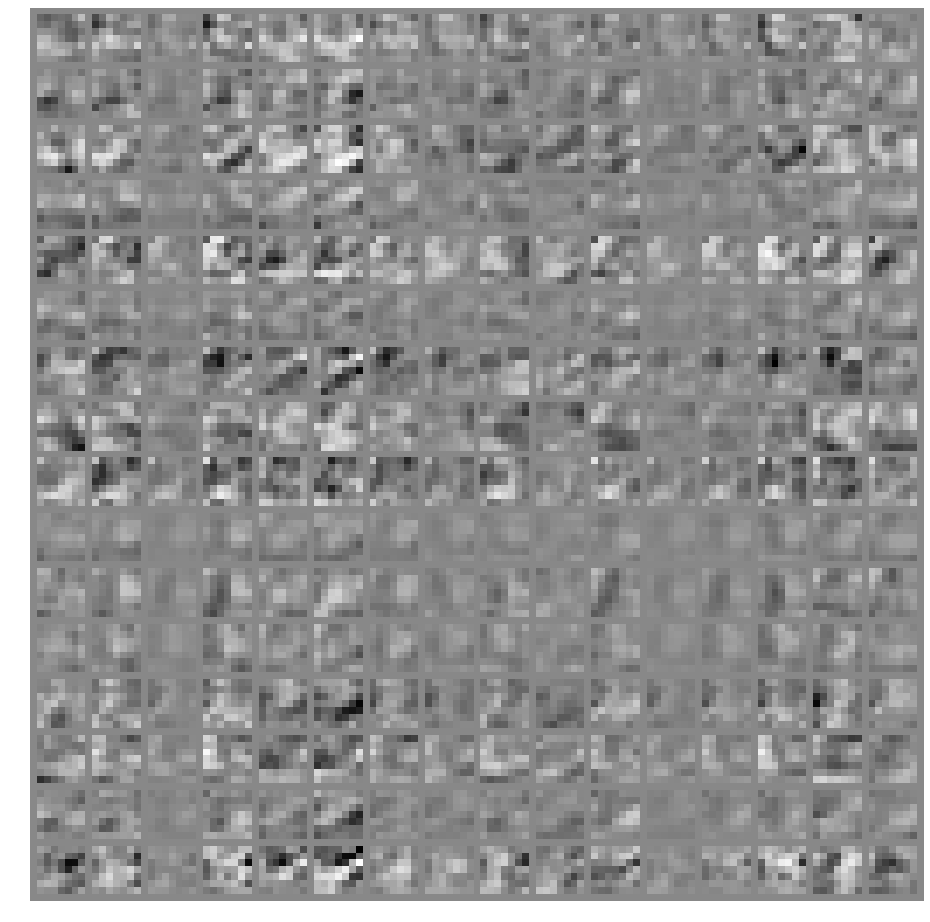

In [24]:
show_filter(conv_filter)

In [25]:
sess.close()